<a href="https://colab.research.google.com/github/lj89/Colab/blob/master/Copy_of_CapstoneB_Fixed%26Rolling_CNNLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Univariate time series - CNN LSTM model

## Data Prep

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

TensorFlow 2.x selected.
2.1.0


In [0]:
# allow access to google drive files
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
chain_dict = {"WESTERN BEV LIQ TX":"WB","SPEC S LIQUOR":"SPECS","THE BARREL HOUSE":"BARREL"}

# change to pull data for another product/customer
#chain = "SPEC S LIQUOR"
chain = "WESTERN BEV LIQ TX"
#chain = "THE BARREL HOUSE"
chain_abbr = chain_dict.get(chain)

prod_name = "TAAKA VODKA 80 BLUE PET 375M"
#prod_name = "MCCORMICK VODKA 80 PET 1L"


data_path = "/content/drive/My Drive/Colab Notebooks/Capstone/data/"
data_filename = data_path + chain_abbr + "_" + prod_name + ".csv"
print(data_filename)

/content/drive/My Drive/Colab Notebooks/Capstone/data/WB_TAAKA VODKA 80 BLUE PET 375M.csv


In [0]:
import csv
time_step = []
std_cases = []

with open(data_filename) as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader) #do not want to read in header
  for row in reader:
    std_cases.append(float(row[4])) # column for standard cases
    time_step.append(int(row[7])) # column for index

series = np.array(std_cases)
time = np.array(time_step)

In [0]:
time.shape[0]

62

In [0]:
print(series)
print(time)

[ 5.   2.   5.   3.   1.   1.   3.   5.   4.  10.  10.  18.  15.  12.
 15.   8.  15.  45.  10.  21.  24.  17.  30.  18.  24.  30.  39.  19.
 33.  40.  28.  37.  39.  36.  37.  37.  37.6 49.  34.  47.  47.  53.
 41.  59.  41.  37.  54.  38.  55.  46.  58.  48.  58.  63.  57.  73.
 52.  57.  49.  42.  57.  58. ]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61]


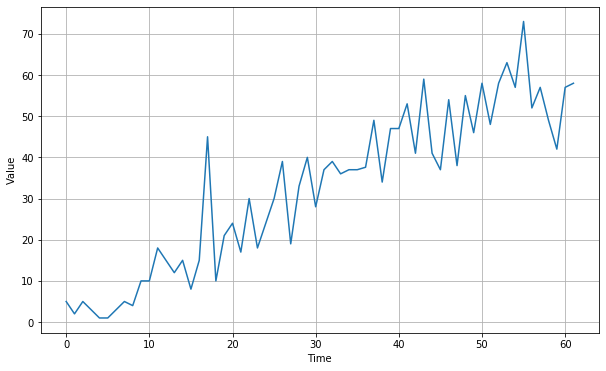

In [0]:
# plot time series
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [0]:
# NOTE: different than biLSTM code
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [0]:
window_size = 12
batch_size = 10
shuffle_buffer_size = 30  

## Fixed Partition

In [0]:
# fixed partition predictions
n = time.shape[0]
n_fore = 23 # fixed test size

split_time = n - n_fore 
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

#### Tune parameters

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size=12, batch_size=30, shuffle_buffer=shuffle_buffer_size)
test_set = windowed_dataset(x_valid, window_size=12, batch_size=30, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
#optimizer = 'adam'
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500,validation_data=test_set)

Epoch 1/500
1/1 [==============================] - 2s 2s/step - loss: 26.6344 - mae: 27.1315 - val_loss: 40.4384 - val_mae: 40.9373
Epoch 2/500
1/1 [==============================] - 0s 42ms/step - loss: 13.3089 - mae: 13.7991 - val_loss: 23.1317 - val_mae: 23.6262
Epoch 3/500
1/1 [==============================] - 0s 48ms/step - loss: 11.2186 - mae: 11.7022 - val_loss: 19.4855 - val_mae: 19.9811
Epoch 4/500
1/1 [==============================] - 0s 42ms/step - loss: 16.8372 - mae: 17.3295 - val_loss: 17.9912 - val_mae: 18.4886
Epoch 5/500
1/1 [==============================] - 0s 43ms/step - loss: 18.1222 - mae: 18.6207 - val_loss: 16.4538 - val_mae: 16.9496
Epoch 6/500
1/1 [==============================] - 0s 48ms/step - loss: 14.6545 - mae: 15.1515 - val_loss: 22.3648 - val_mae: 22.8629
Epoch 7/500
1/1 [==============================] - 0s 37ms/step - loss: 8.7247 - mae: 9.2126 - val_loss: 35.2713 - val_mae: 35.7713
Epoch 8/500
1/1 [==============================] - 0s 43ms/step - 

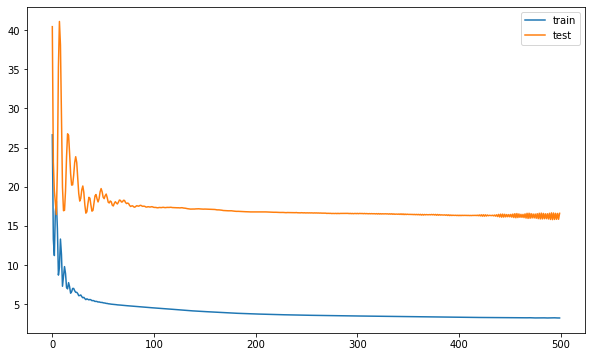

In [0]:
# plot history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [0]:
# decide model params
NUM_EPOCHS = 100
OPTIMIZER = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)

#### Final fixed-partition model

In [0]:
# re-run with chosen params
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size=12, batch_size=30, shuffle_buffer=shuffle_buffer_size)
test_set = windowed_dataset(x_valid, window_size=12, batch_size=30, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


model.compile(loss=tf.keras.losses.Huber(),
              optimizer=OPTIMIZER,
              metrics=["mae"])
history = model.fit(train_set,epochs=NUM_EPOCHS,validation_data=test_set)

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 26.6344 - mae: 27.1315 - val_loss: 40.4384 - val_mae: 40.9373
Epoch 2/100
1/1 [==============================] - 0s 46ms/step - loss: 13.3089 - mae: 13.7991 - val_loss: 23.1317 - val_mae: 23.6262
Epoch 3/100
1/1 [==============================] - 0s 44ms/step - loss: 11.2186 - mae: 11.7022 - val_loss: 19.4855 - val_mae: 19.9811
Epoch 4/100
1/1 [==============================] - 0s 40ms/step - loss: 16.8372 - mae: 17.3295 - val_loss: 17.9912 - val_mae: 18.4886
Epoch 5/100
1/1 [==============================] - 0s 40ms/step - loss: 18.1222 - mae: 18.6207 - val_loss: 16.4538 - val_mae: 16.9496
Epoch 6/100
1/1 [==============================] - 0s 59ms/step - loss: 14.6545 - mae: 15.1515 - val_loss: 22.3648 - val_mae: 22.8629
Epoch 7/100
1/1 [==============================] - 0s 47ms/step - loss: 8.7247 - mae: 9.2126 - val_loss: 35.2713 - val_mae: 35.7713
Epoch 8/100
1/1 [==============================] - 0s 41ms/step - 

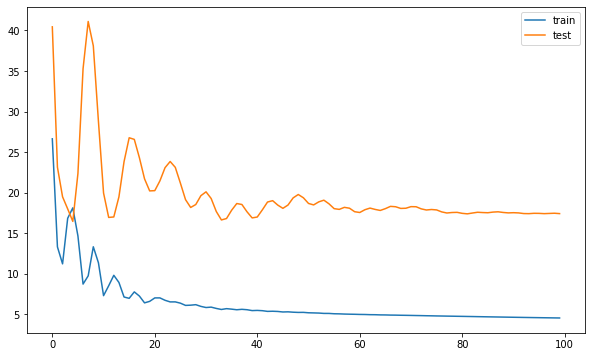

In [0]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

#### Forecasts using rolling test data

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
print(rnn_forecast.shape)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
print(rnn_forecast.shape)

(51, 12, 1)
(23,)


In [0]:
n

62

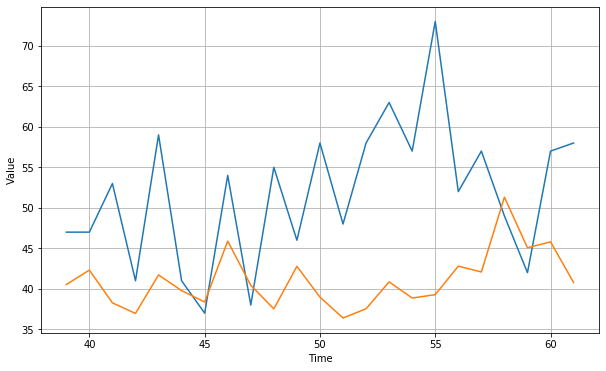

In [0]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [0]:
mae = tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()
mae

11.477638

#### Forecasts with no knowledge of test data (TODO fix, not sure if working correctly)

In [0]:
# my own forecast function (doesn't use test data)
def my_forecast(model, x_train, window_size, n_steps):
  forecast = []
  for i in range(n_steps):
    concat = np.concatenate((x_train, forecast))
    window = concat[len(concat) - window_size:]
    window = window.reshape((len(window),1))

    # make forecast
    #forecast.append(model.predict(window)[0,0])
    forecast.append(model_forecast(model, window, window_size)[0,-1,0])
  return forecast

'''
# debugging
forecast = []
i = 0
concat = np.concatenate((x_train,forecast))
window = concat[len(concat) - window_size:]
w2 = window.reshape((len(window),1))
model_forecast(model,w2,window_size)
#model.predict(window)
'''

#model_forecast(model, series[..., np.newaxis], window_size)
#model.predict(x_train[len(x_train) - window_size:][..., np.newaxis])


my_result = my_forecast(model,x_train,window_size,n_fore)

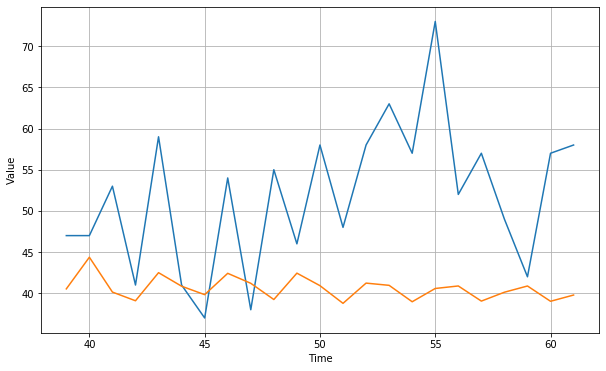

In [0]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, my_result)

In [0]:
mae = tf.keras.metrics.mean_absolute_error(x_valid, my_result).numpy()
mae

11.662255

## Rolling Window

In [0]:
# forecasts with rolling window

n = time.shape[0]

train_size = 24
horizon = [6, 12, 23] # forecast for multiple horizons
#num_windows = n - train_size - horizon   # ERROR - should have + 1
num_windows = []
for h in horizon:
  num_windows.append(n - train_size - h + 1) # FIXED
print(num_windows)

[33, 27, 16]


In [0]:
range(max(num_windows))

range(0, 33)

In [0]:
#mae_list=[]
mae_list = [] 
for h in horizon:
  mae_list.append([]) # store mae lists for multiple horizons

print(mae_list)

[[], [], []]


In [0]:
start_index_list = range(max(num_windows))

In [0]:
# new loop, use multiple horizons

for start_index in start_index_list:
    split_time = start_index + train_size 
    time_train = time[start_index:split_time] # FIXED
    x_train = series[start_index:split_time] # FIXED

    # validate for multiple horizons
    time_valid = [] 
    x_valid = []
    for h in horizon:
      time_valid.append(time[split_time:split_time+h])
      x_valid.append(series[split_time:split_time+h])
    
    # setup model
    tf.keras.backend.clear_session()
    tf.random.set_seed(51)
    np.random.seed(51)

    train_set = windowed_dataset(x_train, window_size=12, batch_size=30, shuffle_buffer=shuffle_buffer_size)

    model = tf.keras.models.Sequential([
      tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                          strides=1, padding="causal",
                          activation="relu",
                          input_shape=[None, 1]),
      tf.keras.layers.LSTM(60, return_sequences=True),
      tf.keras.layers.LSTM(60, return_sequences=True),
      tf.keras.layers.Dense(30, activation="relu"),
      tf.keras.layers.Dense(10, activation="relu"),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 400)
    ])

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=OPTIMIZER,
                  metrics=["mae"])
    history = model.fit(train_set,epochs=NUM_EPOCHS,verbose=0)

    # get forecasts for multiple horizons
    results_h = []
    for h in horizon:
      results_h.append([])

    # make a bunch of forecasts
    rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
    rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
    
    # narrow down to correct indices for horizon
    for i in range(len(horizon)):
      if start_index < num_windows[i]: # don't add forecasts (or MAE) if past the number of windows for that test set size
        results_h[i] = rnn_forecast[:horizon[i]]
        mae_CNN_LSTM=tf.keras.metrics.mean_absolute_error(x_valid[i], results_h[i]).numpy()
        mae_list[i].append(mae_CNN_LSTM)
        print("horizon " + str(horizon[i]) + " MAE: " + str(mae_CNN_LSTM))
    
    print(start_index)

horizon 6 MAE: 7.670901
horizon 12 MAE: 8.787738
horizon 23 MAE: 11.082567
0
horizon 6 MAE: 10.328098
horizon 12 MAE: 13.356135
horizon 23 MAE: 18.737429
1
horizon 6 MAE: 11.917239
horizon 12 MAE: 14.221234
horizon 23 MAE: 18.618122
2
horizon 6 MAE: 10.807475
horizon 12 MAE: 12.114705
horizon 23 MAE: 16.08301
3
horizon 6 MAE: 8.891952
horizon 12 MAE: 9.471889
horizon 23 MAE: 12.852166
4
horizon 6 MAE: 6.9419694
horizon 12 MAE: 7.8268332
horizon 23 MAE: 10.025582
5
horizon 6 MAE: 2.9431455
horizon 12 MAE: 5.2961135
horizon 23 MAE: 6.5493083
6
horizon 6 MAE: 3.0313454
horizon 12 MAE: 4.780829
horizon 23 MAE: 6.1436543
7
horizon 6 MAE: 3.613311
horizon 12 MAE: 5.6288967
horizon 23 MAE: 6.85219
8
horizon 6 MAE: 3.957433
horizon 12 MAE: 5.3731017
horizon 23 MAE: 7.3771853
9
horizon 6 MAE: 4.470614
horizon 12 MAE: 5.979725
horizon 23 MAE: 7.711545
10
horizon 6 MAE: 4.5988464
horizon 12 MAE: 6.1524415
horizon 23 MAE: 8.293483
11
horizon 6 MAE: 6.4891515
horizon 12 MAE: 6.349163
horizon 23 MAE

In [0]:
print(num_windows)
print(len(mae_list[0])) # should be num_windows[0]
print(len(mae_list[1])) # should be num_windows[1]
print(len(mae_list[2])) # should be num_windows[2]
print(mae_list[0])
print(mae_list[1])
print(mae_list[2])

[33, 27, 16]
33
27
16
[7.670901, 10.328098, 11.917239, 10.807475, 8.891952, 6.9419694, 2.9431455, 3.0313454, 3.613311, 3.957433, 4.470614, 4.5988464, 6.4891515, 6.7787185, 8.053064, 8.042468, 7.472942, 7.9240355, 6.0146146, 8.169563, 6.012684, 7.592853, 7.4299197, 6.7175865, 11.086661, 7.3080297, 10.858596, 10.193229, 11.2893, 10.004853, 9.173713, 7.7145824, 5.1292377]
[8.787738, 13.356135, 14.221234, 12.114705, 9.471889, 7.8268332, 5.2961135, 4.780829, 5.6288967, 5.3731017, 5.979725, 6.1524415, 6.349163, 7.438393, 7.208241, 8.834884, 9.506585, 9.332921, 9.110509, 9.544894, 9.761754, 8.339623, 10.586156, 8.208354, 10.423798, 7.758574, 8.732204]
[11.082567, 18.737429, 18.618122, 16.08301, 12.852166, 10.025582, 6.5493083, 6.1436543, 6.85219, 7.3771853, 7.711545, 8.293483, 8.9561405, 9.836847, 10.623538, 11.4701]


In [0]:
def mean(lst): 
    return sum(lst) / len(lst) 

In [0]:
average_mae = []
for i in range(len(horizon)):
  average_mae.append(mean(mae_list[i]))

In [0]:
average_mae # average MAE for each horizon

[7.534185821359808, 8.523173897354692, 10.700804263353348]

## Testing on single iteration (single window)

In [0]:
start_index = 18

In [0]:
split_time = start_index + train_size 
split_time

42

In [0]:
time_train = time[start_index:split_time]
print(time_train)
print(len(time_train)) # make sure training set is always 24 points

[18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41]
24


In [0]:
# original code
time_train = time[start_index:split_time]
x_train = series[start_index:split_time]
time_valid = time[split_time:split_time+horizon[2]]
x_valid = series[split_time:split_time+horizon[2]]

print(time_valid)
print(len(time_valid))
print(x_valid)

# note that if start index >= num_windows, the test set is reduced (so don't include)

[42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61]
20
[41. 59. 41. 37. 54. 38. 55. 46. 58. 48. 58. 63. 57. 73. 52. 57. 49. 42.
 57. 58.]


In [0]:
time_valid = [] # validate for multiple horizons
x_valid = []
for h in horizon:
  time_valid.append(time[split_time:split_time+h])
  x_valid.append(series[split_time:split_time+h])

print(time_valid)
print(x_valid)

[array([42, 43, 44, 45, 46, 47]), array([42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]), array([42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
       59, 60, 61])]
[array([41., 59., 41., 37., 54., 38.]), array([41., 59., 41., 37., 54., 38., 55., 46., 58., 48., 58., 63.]), array([41., 59., 41., 37., 54., 38., 55., 46., 58., 48., 58., 63., 57.,
       73., 52., 57., 49., 42., 57., 58.])]


In [0]:
# train model on 24 points
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size=12, batch_size=30, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=OPTIMIZER,
              metrics=["mae"])
history = model.fit(train_set,epochs=NUM_EPOCHS)

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 31.8981 - mae: 32.3981
Epoch 2/100
1/1 [==============================] - 0s 25ms/step - loss: 17.7108 - mae: 18.2108
Epoch 3/100
1/1 [==============================] - 0s 20ms/step - loss: 10.6541 - mae: 11.1487
Epoch 4/100
1/1 [==============================] - 0s 18ms/step - loss: 17.1503 - mae: 17.6435
Epoch 5/100
1/1 [==============================] - 0s 19ms/step - loss: 12.5310 - mae: 13.0272
Epoch 6/100
1/1 [==============================] - 0s 19ms/step - loss: 6.5318 - mae: 7.0183
Epoch 7/100
1/1 [==============================] - 0s 17ms/step - loss: 8.3081 - mae: 8.8013
Epoch 8/100
1/1 [==============================] - 0s 17ms/step - loss: 10.0521 - mae: 10.5447
Epoch 9/100
1/1 [==============================] - 0s 17ms/step - loss: 8.2384 - mae: 8.7350
Epoch 10/100
1/1 [==============================] - 0s 16ms/step - loss: 4.9890 - mae: 5.4686
Epoch 11/100
1/1 [==============================] - 0s 18ms

In [0]:
# original code
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

print(len(rnn_forecast))
print(rnn_forecast)

20
[42.59435  42.318684 42.5043   41.830097 44.187504 39.665134 40.851032
 42.85339  40.73466  43.586166 42.430115 44.306213 43.213375 45.687992
 44.963497 44.855164 46.078785 42.277058 43.343906 41.446083]


In [0]:
x_valid[2]

array([41., 59., 41., 37., 54., 38., 55., 46., 58., 48., 58., 63., 57.,
       73., 52., 57., 49., 42., 57., 58.])

In [0]:
mae_LSTM=tf.keras.metrics.mean_absolute_error(x_valid[2], rnn_forecast).numpy()
mae_LSTM

10.150718

In [0]:
# get forecasts for multiple horizons
results_h = []
for h in horizon:
  results_h.append([])

print(results_h)

[[], [], []]


In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

for i in range(len(horizon)):
  if start_index < num_windows[i]: # don't add forecasts (or MAE) if past the number of windows for that test set size
    results_h[i] = rnn_forecast[:horizon[i]]

In [0]:
print(results_h[0])
print(len(results_h[0]))
print(results_h[1])
print(len(results_h[1]))
print(results_h[2]) # empty because start_index >= num_windows[2]
print(len(results_h[2]))

[42.59435  42.318684 42.5043   41.830097 44.187504 39.665134]
6
[42.59435  42.318684 42.5043   41.830097 44.187504 39.665134 40.851032
 42.85339  40.73466  43.586166 42.430115 44.306213]
12
[]
0


In [0]:
print(tf.keras.metrics.mean_absolute_error(x_valid[0], results_h[0]).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid[1], results_h[1]).numpy())
#print(tf.keras.metrics.mean_absolute_error(x_valid[2], results_h[2]).numpy())

6.0146155
9.110509
